#Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, classification_report

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Rescaling

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

!pip3 install --upgrade gdown


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# workaround to download large data from gdrive using `id` from gdrive
# dataspec = "1VMAu4ve6ejhl8BealS42MR8OCRyMug9c"
# metadata = "1gXPzmS9UKvAHvBRxOvRuDsnVe2DLfWL"
# snapshot = "1ls3dqgUw4RAkPw39BeGYU9OelLNGWq_7"

!gdown "1VMAu4ve6ejhl8BealS42MR8OCRyMug9c"
!gdown "1gXPzmS9UKvAHvBRxOvRuDsnVe2DLfWL_"
!gdown "1ls3dqgUw4RAkPw39BeGYU9OelLNGWq_7"

Downloading...
From: https://drive.google.com/uc?id=1VMAu4ve6ejhl8BealS42MR8OCRyMug9c
To: d:\ClonedRepositories\predict-tourist-attraction\dataset_spec.pb

  0%|          | 0.00/61.0 [00:00<?, ?B/s]
100%|██████████| 61.0/61.0 [00:00<?, ?B/s]
Downloading...
From: https://drive.google.com/uc?id=1gXPzmS9UKvAHvBRxOvRuDsnVe2DLfWL_
To: d:\ClonedRepositories\predict-tourist-attraction\snapshot.metadata

  0%|          | 0.00/42.0 [00:00<?, ?B/s]
100%|██████████| 42.0/42.0 [00:00<?, ?B/s]
Downloading...
From: https://drive.google.com/uc?id=1ls3dqgUw4RAkPw39BeGYU9OelLNGWq_7
To: d:\ClonedRepositories\predict-tourist-attraction\00000000.snapshot

  0%|          | 0.00/1.97G [00:00<?, ?B/s]
  0%|          | 524k/1.97G [00:00<07:22, 4.46MB/s]
  0%|          | 2.10M/1.97G [00:00<03:05, 10.6MB/s]
  0%|          | 8.39M/1.97G [00:00<01:02, 31.4MB/s]
  1%|          | 15.7M/1.97G [00:00<00:42, 46.5MB/s]
  1%|▏         | 25.7M/1.97G [00:00<00:31, 61.7MB/s]
  2%|▏         | 32.0M/1.97G [00:00<00:32, 59.0M

In [43]:
# to follow keras dataset directory location, will probably change this to csv later

!mkdir "dataset/3188285490804691313/00000000.shard/"
!move dataset_spec.pb dataset/dataset_spec.pb
!move snapshot.metadata dataset/snapshot.metadata
!move 00000000.snapshot dataset/3188285490804691313/00000000.shard/00000000.snapshot

        1 file(s) moved.
        1 file(s) moved.
        1 file(s) moved.


In [13]:
resolution = 128
path = "."

dataset = tf.data.Dataset.load(path=path)

dataset

<_LoadDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#Preparing Data

In [14]:
# Convert the dataset to NumPy arrays
x_train, y_train = [], []
x_test, y_test = [], []

for batch in dataset.as_numpy_iterator():
    x, y = batch
    x_train.append(x)
    y_train.append(y)
    
# Convert the lists to NumPy arrays
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Split the dataset into training and testing sets, train = 80%, test = 20%
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# test = 10%, val = 10%
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [15]:
class_names = ['ancient_city_(mueang_boran)', 'big_buddha_phuket', 'big_buddha_temple_(wat_phra_yai)', 
               'chaithararam_temple_(wat_chalong)', 'chinatown_-_bangkok', 'historic_city_of_ayutthaya', 
               'jim_thompson_house', 'sukhothai_historical_park', 'temple_of_dawn_(wat_arun)', 'temple_of_the_emerald_buddha_(wat_phra_kaew)', 
               'temple_of_the_golden_buddha_(wat_traimit)', 'the_golden_mount_(wat_saket)', 'the_grand_palace', 'the_sanctuary_of_truth', 
               'tiger_cave_temple_(wat_tham_suea)', 'wat_chedi_luang_varavihara', 'wat_phra_chetuphon_(wat_pho)', 'wat_phra_singh', 'wat_rong_khun', 'wat_umong']

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8033, 128, 128, 3), (1004, 128, 128, 3), (8033,), (1004,))

In [16]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print('train class: ', train_classes)
print('train count: ', train_counts)
val_classes, val_counts = np.unique(y_val, return_counts=True)
print('val class: ', val_classes)
print('val count: ', val_counts)
test_classes, test_counts = np.unique(y_test, return_counts=True)
print('test class: ', test_classes)
print('test count: ', test_counts)

train class:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train count:  [391 424 408 390 457 406 322 347 409 495 341 405 407 362 420 384 455 413
 366 431]
val class:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
val count:  [43 45 51 62 54 40 44 38 49 50 49 47 62 42 57 48 63 60 51 50]
test class:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
test count:  [50 50 46 66 55 53 37 40 46 70 42 56 74 39 48 39 49 48 50 46]


In [17]:
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

x_train = x_train.reshape(-1, resolution, resolution, 3)
x_val = x_val.reshape(-1, resolution, resolution, 3)
x_test = x_test.reshape(-1, resolution, resolution, 3)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Example image from some of the classe

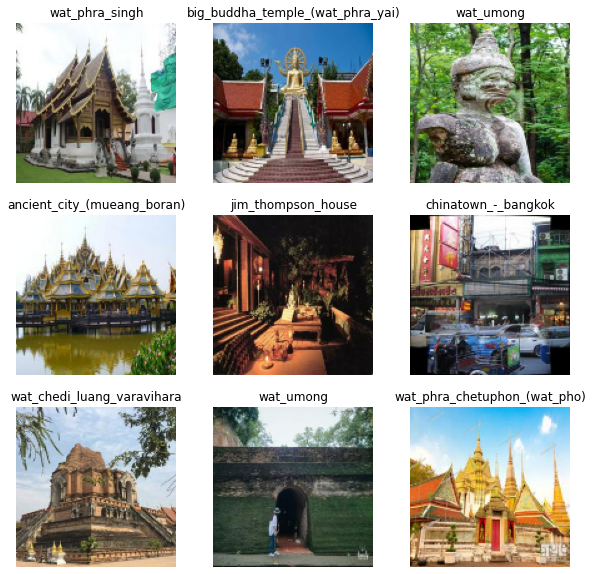

In [18]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train[i])
    label = class_names[y_train[i].argmax()]
    ax.set(title = f"{label}");
    ax.set_axis_off()

#Model use for identify location name in the picture

In [19]:
num_classes = 20

model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(resolution, resolution, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                        

#Preparing Data Augmentation(ImageDataGenerator) and Confusion Matrix

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


train_gen = datagen.flow(x_train, y_train, batch_size=32)

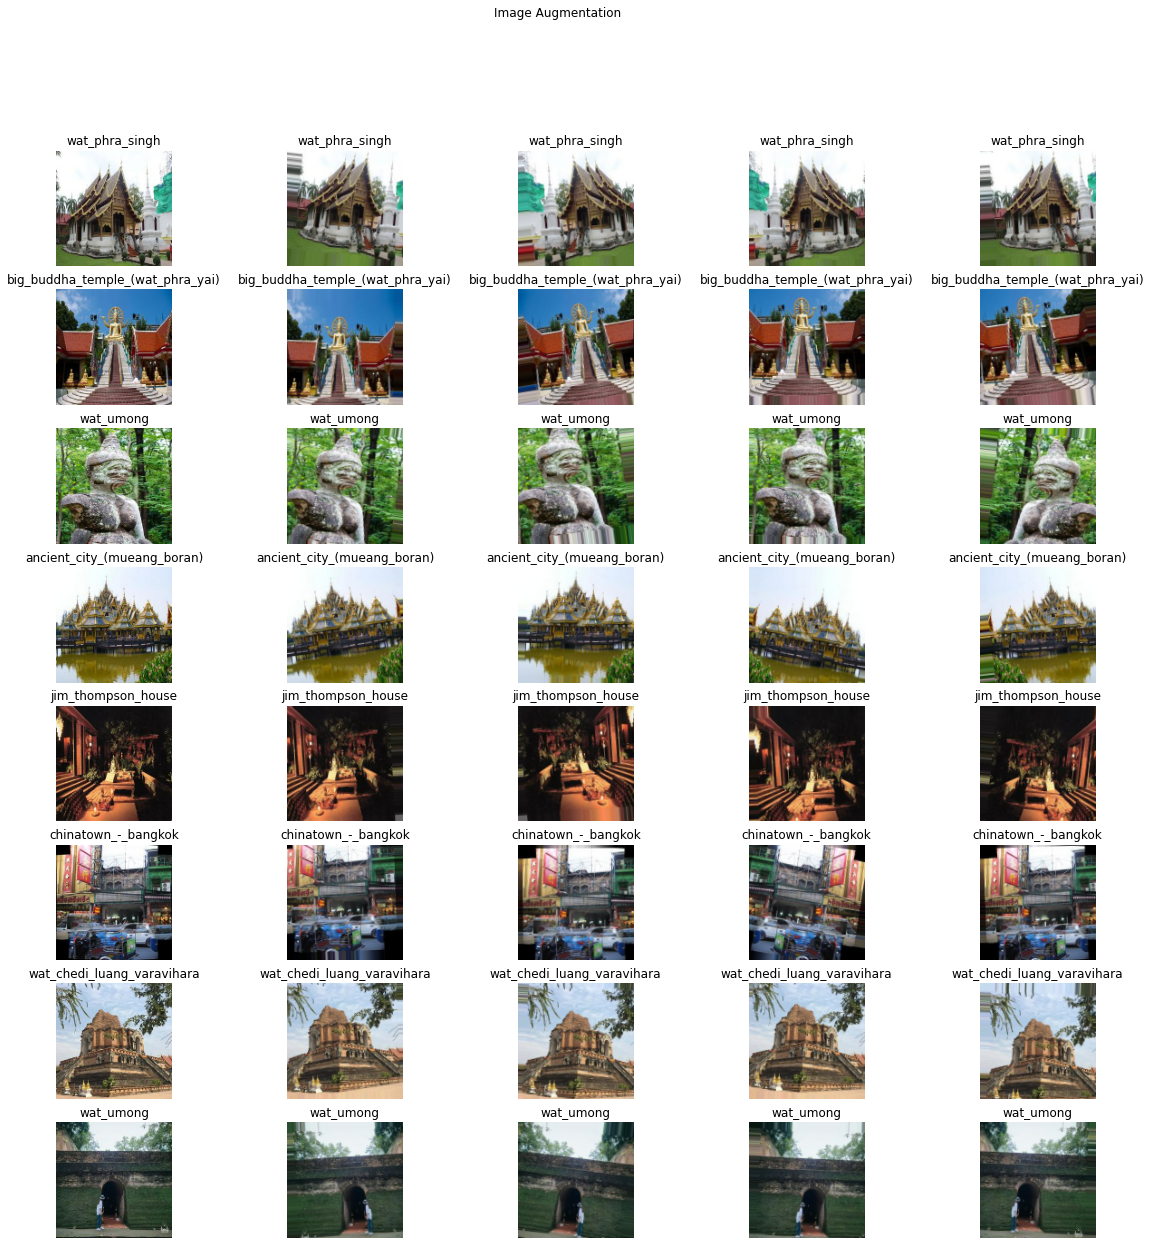

In [35]:
n_rows, n_cols = 8, 5

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Image Augmentation")

for i in range(0, n_rows):
  image = np.expand_dims(x_train[i], axis=0)
  label = class_names[np.argmax(y_train[i])]

  it = datagen.flow(image, batch_size=1)
  for j in range(0, n_cols):
    ax = plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
    if j == 0:
      plt.imshow(image[0])
    else:
      batch = it.next()
      plt.imshow(batch[0])
    plt.title(label)
    plt.axis('off')
  # plt.tight_layout()
plt.show()

In [36]:
def plot_confusion_matrix(cm, class_name, title="Confusion Matrix", cmap=None, normalize=False):
  if cmap is None:
    cmap = plt.get_cmap('Oranges')

  plt.figure(figsize=(10, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
    
  if class_name is not None:
      tick_marks = np.arange(len(class_name))
      plt.xticks(tick_marks, class_name, rotation=90)
      plt.yticks(tick_marks, class_name)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylim(len(class_name)-0.5, -0.5)
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
  plt.show()

#Fitting Model / Plotting Graph / Confusion Matrix and Classification Report

In [ ]:
epochs = 50
batch_size = 16

##Fitting Model with ImageDataGenerator

In [ ]:
model_gen = model
history_gen = model_gen.fit(train_gen, 
                              epochs = epochs,
                              batch_size=batch_size, 
                              validation_data =(x_val, y_val))

Epoch 1/50
252/252 [==============================] - 52s 153ms/step - loss: 3.3533 - accuracy: 0.1413 - val_loss: 3.2520 - val_accuracy: 0.0965
Epoch 2/50
252/252 [==============================] - 36s 142ms/step - loss: 2.8644 - accuracy: 0.2095 - val_loss: 2.4955 - val_accuracy: 0.2627
Epoch 3/50
252/252 [==============================] - 36s 142ms/step - loss: 2.5976 - accuracy: 0.2589 - val_loss: 2.3701 - val_accuracy: 0.3144
Epoch 4/50
252/252 [==============================] - 36s 143ms/step - loss: 2.3936 - accuracy: 0.3041 - val_loss: 2.3589 - val_accuracy: 0.3085
Epoch 5/50
252/252 [==============================] - 37s 145ms/step - loss: 2.2699 - accuracy: 0.3374 - val_loss: 2.2974 - val_accuracy: 0.3254
Epoch 6/50
252/252 [==============================] - 35s 137ms/step - loss: 2.1585 - accuracy: 0.3671 - val_loss: 2.4321 - val_accuracy: 0.3055
Epoch 7/50
252/252 [==============================] - 36s 142ms/step - loss: 2.0840 - accuracy: 0.3789 - val_loss: 2.0535 - val_ac

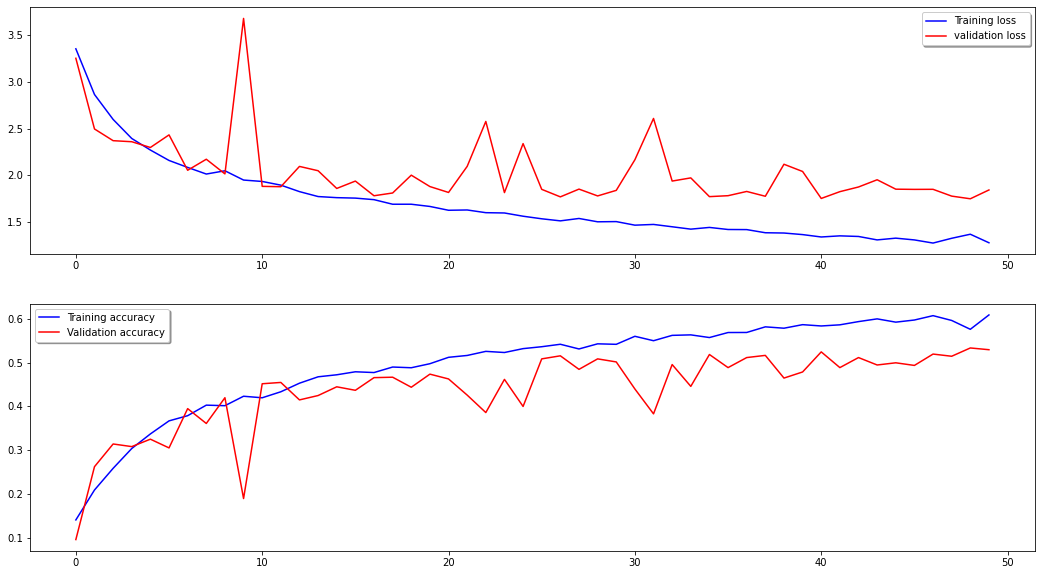

In [ ]:
def plot(history):
  fig, ax = plt.subplots(2,1, figsize=(18, 10))
  ax[0].plot(history.history['loss'], color='b', label="Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
  legend = ax[1].legend(loc='best', shadow=True)

plot(history_gen)

### Confusion Matrix and Classification Report of Fitting Model with ImageDataGenerator

In [ ]:
y_predict_gen = model_gen.predict(x_test)

y_true_gen = [np.argmax(i) for i in y_test]
y_predict_gen = [np.argmax(i) for i in y_predict_gen]
cm_gen = confusion_matrix(y_true_gen, y_predict_gen)

32/32 [==============================] - 0s 10ms/step


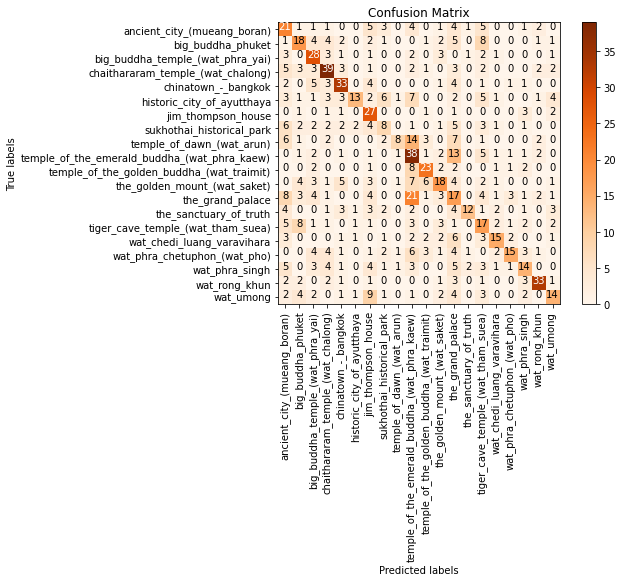

In [ ]:
plot_confusion_matrix(cm_gen, class_names)

In [ ]:
cr = classification_report(y_true_gen, y_predict_gen, target_names=class_names, digits=4, output_dict=True)
for class_name in class_names:
  print(class_name)
  print("Precision:", cr[class_name]["precision"])
  print("Recall:", cr[class_name]["recall"])
  print("F1-score:", cr[class_name]["f1-score"])
  print("Support:", cr[class_name]["support"])
  print("----------------------------------------------------")

ancient_city_(mueang_boran)
Precision: 0.27631578947368424
Recall: 0.42
F1-score: 0.33333333333333337
Support: 50
----------------------------------------------------
big_buddha_phuket
Precision: 0.3673469387755102
Recall: 0.36
F1-score: 0.3636363636363636
Support: 50
----------------------------------------------------
big_buddha_temple_(wat_phra_yai)
Precision: 0.4307692307692308
Recall: 0.6086956521739131
F1-score: 0.5045045045045046
Support: 46
----------------------------------------------------
chaithararam_temple_(wat_chalong)
Precision: 0.5416666666666666
Recall: 0.5909090909090909
F1-score: 0.5652173913043478
Support: 66
----------------------------------------------------
chinatown_-_bangkok
Precision: 0.559322033898305
Recall: 0.6
F1-score: 0.5789473684210527
Support: 55
----------------------------------------------------
historic_city_of_ayutthaya
Precision: 0.6842105263157895
Recall: 0.24528301886792453
F1-score: 0.36111111111111105
Support: 53
---------------------------

##Fitting Model without ImageDataGenerator

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/50
503/503 [==============================] - 16s 31ms/step - loss: 1.5516 - accuracy: 0.5312 - val_loss: 1.8529 - val_accuracy: 0.4836
Epoch 2/50
503/503 [==============================] - 15s 31ms/step - loss: 1.3632 - accuracy: 0.5856 - val_loss: 1.9902 - val_accuracy: 0.4766
Epoch 3/50
503/503 [==============================] - 15s 30ms/step - loss: 1.0599 - accuracy: 0.6776 - val_loss: 2.7370 - val_accuracy: 0.3751
Epoch 4/50
503/503 [==============================] - 15s 30ms/step - loss: 0.7441 - accuracy: 0.7716 - val_loss: 1.7309 - val_accuracy: 0.5403
Epoch 5/50
503/503 [==============================] - 15s 30ms/step - loss: 0.4492 - accuracy: 0.8679 - val_loss: 1.7725 - val_accuracy: 0.5353
Epoch 6/50
503/503 [==============================] - 15s 30ms/step - loss: 0.3207 - accuracy: 0.9090 - val_loss: 1.9504 - val_accuracy: 0.5343
Epoch 7/50
503/503 [==============================] - 15s 30ms/step - loss: 0.5741 - accuracy: 0.8206 - val_loss: 2.1522 - val_accuracy:

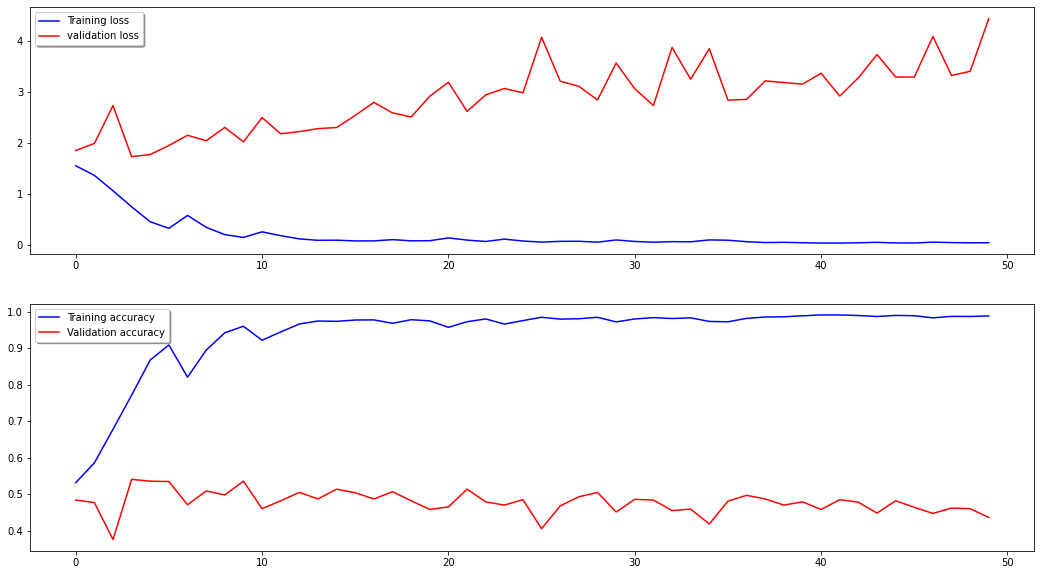

In [ ]:
plot(history)

### Confusion Matrix and Classification Report of Fitting Model without ImageDataGenerator

In [ ]:
y_predict = model.predict(x_test)

y_true = [np.argmax(i) for i in y_test]
y_predict = [np.argmax(i) for i in y_predict]
cm = confusion_matrix(y_true, y_predict)

32/32 [==============================] - 0s 10ms/step


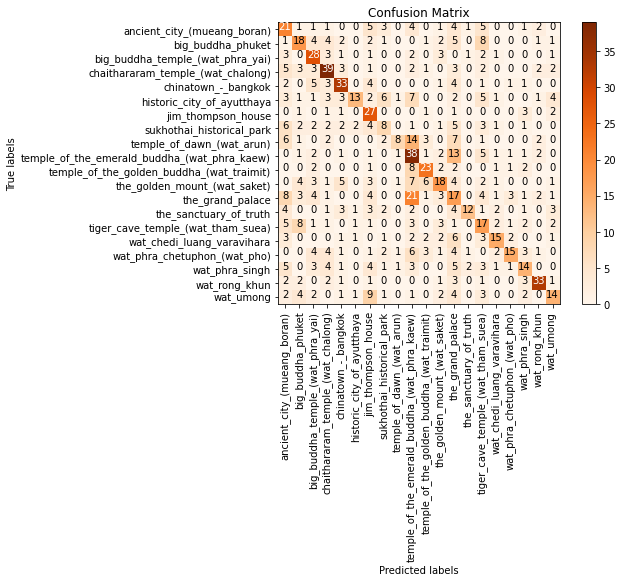

In [ ]:
plot_confusion_matrix(cm, class_names)

In [ ]:
cr = classification_report(y_true, y_predict, target_names=class_names, digits=4, output_dict=True)
for class_name in class_names:
  print(class_name)
  print("Precision:", cr[class_name]["precision"])
  print("Recall:", cr[class_name]["recall"])
  print("F1-score:", cr[class_name]["f1-score"])
  print("Support:", cr[class_name]["support"])
  print("----------------------------------------------------")

ancient_city_(mueang_boran)
Precision: 0.27631578947368424
Recall: 0.42
F1-score: 0.33333333333333337
Support: 50
----------------------------------------------------
big_buddha_phuket
Precision: 0.3673469387755102
Recall: 0.36
F1-score: 0.3636363636363636
Support: 50
----------------------------------------------------
big_buddha_temple_(wat_phra_yai)
Precision: 0.4307692307692308
Recall: 0.6086956521739131
F1-score: 0.5045045045045046
Support: 46
----------------------------------------------------
chaithararam_temple_(wat_chalong)
Precision: 0.5416666666666666
Recall: 0.5909090909090909
F1-score: 0.5652173913043478
Support: 66
----------------------------------------------------
chinatown_-_bangkok
Precision: 0.559322033898305
Recall: 0.6
F1-score: 0.5789473684210527
Support: 55
----------------------------------------------------
historic_city_of_ayutthaya
Precision: 0.6842105263157895
Recall: 0.24528301886792453
F1-score: 0.36111111111111105
Support: 53
---------------------------